In [1]:
import torch

In [6]:
torch.finfo(torch.bfloat16)

finfo(resolution=0.01, min=-3.38953e+38, max=3.38953e+38, eps=0.0078125, smallest_normal=1.17549e-38, tiny=1.17549e-38, dtype=bfloat16)

In [1]:
%load_ext autoreload
%autoreload 2
from utils.utils import *
from utils.utils_train import *
from utils.utils_imports import *

In [2]:
# Load SBERT Embeddings
queries, query_embeddings, product_embeddings = load_raw_queries()

# load ids_toys from disk
with open('output/ids_toys.pkl', 'rb') as file:
    ids_toys = pickle.load(file)
    print(f"len(ids_toys): {len(ids_toys)}")
    ids_present = [_id for _id in ids_toys if _id in query_embeddings]

# Assemble qb & xb input embeddings
qb = torch.stack([torch.tensor(query_embeddings[_id]) for _id in ids_present])
xb = torch.tensor(np.array([product_embeddings[_id] for _id in ids_present]))

# Split Dataset into Train and Test
(qb_train, qb_test), (xb_train, xb_test), (idx_train, idx_test) = shuffle_and_split(qb, xb, split=0.8, seed=12)
print(f'len(qb_train): {len(qb_train)}')
print(f'len(qb_test): {len(qb_train)}')

# Two-Tower Pytorch Model
d = qb_train.shape[-1]
list_recall3 = []
list_test_epochs = []

# Initialize the network
model = TwoTowerNetwork(d)


loaded (queries, query_embeddings, product_embeddings) from  output/raw_queries.pkl
len(ids_toys): 84373
len(qb_train): 20560
len(qb_test): 20560
dropout         : 0.1
learning_rate   : 0.0001
label_smoothing : 0.35
batch_size      : 512
eval_iter       : 1

TwoTowerNetwork(
  (qb_tower): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=768, out_features=768, bias=False)
  )
  (xb_tower): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=768, out_features=768, bias=False)
  )
  (mlp): Sequential(
    (0): ReLU()
    (1): Dropout(p=0.1, inplace=False)
    (2): Linear(in_features=1536, out_features=1, bias=False)
    (3): Dropout(p=0.1, inplace=False)
  )
)
num_params:2.36 million 


model.fit n:20480, num_batches:40, qb_train.shape: torch.Size([20560, 768])
fused_trainset: (262144, 768) (262144,) 1.07 sec -> epoch 0.025, train_loss: 0.69406
fused_trainset: (262144, 768) (262144,) 1.11 sec -> epoch 0.050, train_loss: 0.68870
fused_trainset: (262144, 768) (262144,) 0.93 sec -> epoch 0.075, train_loss: 0.68323
fused_trainset: (262144, 768) (262144,) 1.05 sec -> epoch 0.100, train_loss: 0.67779
fused_trainset: (262144, 768) (262144,) 1.01 sec -> epoch 0.125, train_loss: 0.67225
fused_trainset: (262144, 768) (262144,) 1.09 sec -> epoch 0.150, train_loss: 0.66654
fused_trainset: (262144, 768) (262144,) 1.12 sec -> epoch 0.175, train_loss: 0.66041
fused_trainset: (262144, 768) (262144,) 1.06 sec -> epoch 0.200, train_loss: 0.65395
fused_trainset: (262144, 768) (262144,) 1.06 sec -> epoch 0.225, train_loss: 0.64703
fused_trainset: (262144, 768) (262144,) 1.06 sec -> epoch 0.250, train_loss: 0.64011
fused_trainset: (262144, 768) (262144,) 1.14 sec -> epoch 0.275, train_los

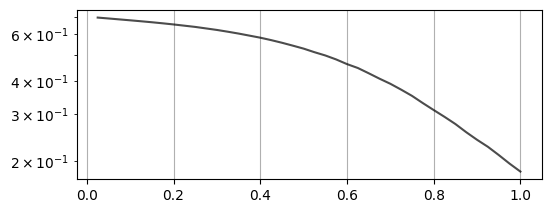

model.fit n:20480, num_batches:40, qb_train.shape: torch.Size([20560, 768])
fused_trainset: (262144, 768) (262144,) 1.26 sec -> epoch 1.025, train_loss: 0.17173
fused_trainset: (262144, 768) (262144,) 1.09 sec -> epoch 1.050, train_loss: 0.15936
fused_trainset: (262144, 768) (262144,) 1.07 sec -> epoch 1.075, train_loss: 0.15173
fused_trainset: (262144, 768) (262144,) 1.09 sec -> epoch 1.100, train_loss: 0.14029
fused_trainset: (262144, 768) (262144,) 1.08 sec -> epoch 1.125, train_loss: 0.13420
fused_trainset: (262144, 768) (262144,) 1.09 sec -> epoch 1.150, train_loss: 0.12848
fused_trainset: (262144, 768) (262144,) 1.09 sec -> epoch 1.175, train_loss: 0.12184
fused_trainset: (262144, 768) (262144,) 1.08 sec -> epoch 1.200, train_loss: 0.11579
fused_trainset: (262144, 768) (262144,) 1.11 sec -> epoch 1.225, train_loss: 0.11106
fused_trainset: (262144, 768) (262144,) 1.07 sec -> epoch 1.250, train_loss: 0.10921
fused_trainset: (262144, 768) (262144,) 1.15 sec -> epoch 1.275, train_los

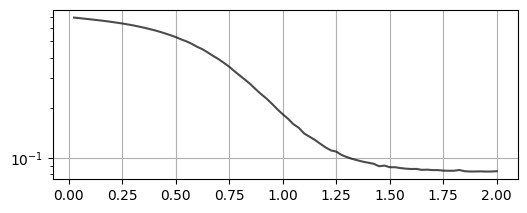

model.fit n:20480, num_batches:40, qb_train.shape: torch.Size([20560, 768])
fused_trainset: (262144, 768) (262144,) 1.05 sec -> epoch 2.025, train_loss: 0.08328
fused_trainset: (262144, 768) (262144,) 1.05 sec -> epoch 2.050, train_loss: 0.08262
fused_trainset: (262144, 768) (262144,) 1.09 sec -> epoch 2.075, train_loss: 0.08319
fused_trainset: (262144, 768) (262144,) 1.04 sec -> epoch 2.100, train_loss: 0.08292
fused_trainset: (262144, 768) (262144,) 1.09 sec -> epoch 2.125, train_loss: 0.08240
fused_trainset: (262144, 768) (262144,) 1.06 sec -> epoch 2.150, train_loss: 0.08315
fused_trainset: (262144, 768) (262144,) 1.08 sec -> epoch 2.175, train_loss: 0.08238
fused_trainset: (262144, 768) (262144,) 1.07 sec -> epoch 2.200, train_loss: 0.08277
fused_trainset: (262144, 768) (262144,) 1.08 sec -> epoch 2.225, train_loss: 0.08317
fused_trainset: (262144, 768) (262144,) 1.04 sec -> epoch 2.250, train_loss: 0.08330
fused_trainset: (262144, 768) (262144,) 1.12 sec -> epoch 2.275, train_los

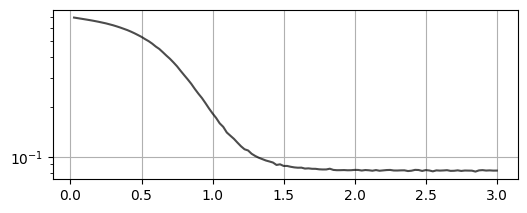

model.fit n:20480, num_batches:40, qb_train.shape: torch.Size([20560, 768])
fused_trainset: (262144, 768) (262144,) 1.06 sec -> 

KeyboardInterrupt: 

In [3]:
%%time
## TRAIN
# Hyperparameters
num_epochs = 1

for i in range(10):
    
    # reshuffle the trainset at beginning of each epoch
    (qb_train, _), (xb_train, _), (_) = shuffle_and_split(qb_train, xb_train, split=1)
    
    # train for 1 epoch
    model.fit(qb_train, xb_train)

    # # write output embeddings to use for eval
    # write_output_embeddings(model, qb_test, xb_test) 

    # # run eval
    # os.system('cd utils && python3 utils_infer.py')

    # # read recall@3 metric written to json file
    # with open('output/recall3.json', 'r') as file:
    #     recall3 = json.load(file)['recall3']
    #     list_recall3.append(recall3) 

    # # monitor metrics to plot recall.
    # list_test_epochs.append(model.epochs[-1])

    if (i+1) % 1 == 0:
        plt.semilogy(model.epochs, model.train_loss, 'k', alpha=.7)
        plt.show()


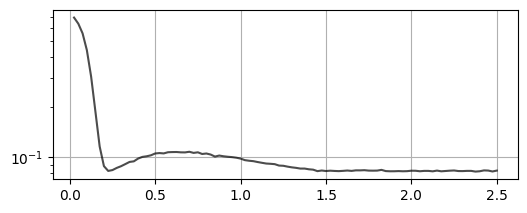

In [4]:
        plt.semilogy(model.epochs, model.train_loss, 'k', alpha=.7)

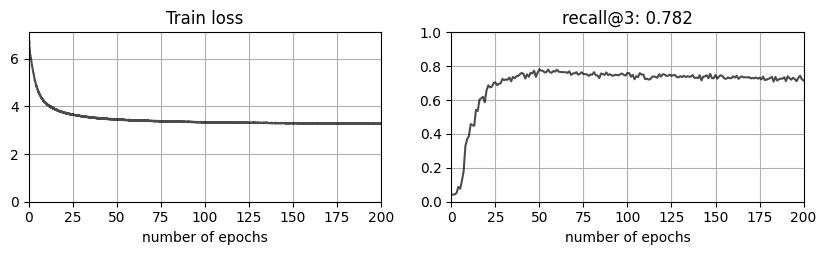

In [4]:
model.plot(qb_train, list_test_epochs, list_recall3)


In [ ]:
# TODO:
# 1. Incorporate a learning_rate scheduler
# 2. print the top 3 results for hits. 
# 3. naive baseline on SBERT embeddings recall@3 = 0.745
# 4. 

### The End

In [1]:
import faiss, numpy as np, pickle, json
with open('output/qb_xb_output.pkl', 'rb') as file:
    (qb_output, xb_output) = pickle.load(file)

# Train the faiss index (Voronai cells + product quantizer)
d = qb_output.shape[1]
nlist = 50  # number of Voronai cells
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist)

index.train(xb_output)
index.add(xb_output)  # add vectors to the index


In [2]:
idx = []
ranks = []
dissatisfaction_report = [] # rank returns None which means, the correct xb is not in top 100
for q in range(len(qb_output)):
    k = 100  # capture 4 nearest neighbors
    D, I = index.search(qb_output[q:q+1], k=k) 
    rank = np.argwhere(I[0] == q)
    rank = rank[0][0] if len(rank) > 0 else None
    idx.append(I[0])
    ranks.append(rank)
    if rank is not None and rank > 0:
        print(rank)
    if rank is None:
        dissatisfaction_report.append(q)
    
print(len(dissatisfaction_report))    

1
2
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
6
1
2
1
1
4
1
1
1
1
1
4
1
1
2
6
1
2
2
1
2
1
1
1
1
1
1
1
4
1
1
1
5
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
11
1
1
1
1
1
1
1
10
1
5
1
1
1
2
1
1
1
2
1
1
1
4
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
4
3
1
1
1
1
1
1
1
16
1
1
1
4
2
1
2
1
2
1
3
2
5
1
1
1
1
2
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
3
1
1
3
1
1
1
1
1
1
1
1
5
1
2
1
1
1
1
2
1
1
2
1
2
1
1
1
1
1
1
5
1
1
1
1
1
3
11
3
2
1
1
1
1
4
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
3
1
1
13
1
2
1
1
1
1
1
2
2
1
1
1
1
21
1
2
1
2
2
1
1
9
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
9
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
2
4
3
1
1
1
1
1
1
2
2
1
2
5
3
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
5
1
1
2
2
1
1
1
1
1
1
1
2
2
1
1
1
1
1
2
5
1
1
1
1
2
2
2
1
1
1
1
1
1
3
1
2
2
1
1
1
4
1
1
2
2
1
1
2
3
1
1
1
1
1
1
1
1
1
2
1
1
3
2
1
1
1
1
1083


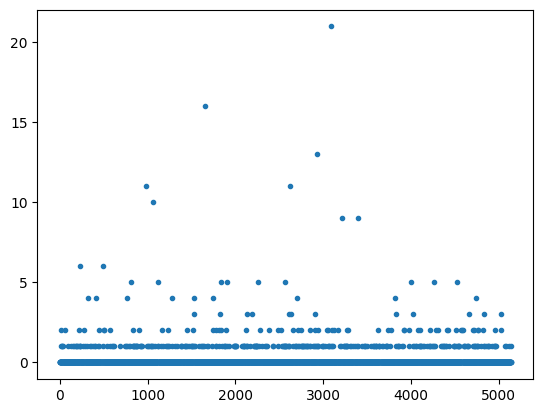

In [3]:
import matplotlib.pylab as plt
plt.plot(ranks, '.')

In [20]:
with open('output/product_info.json', 'r') as file:
    info = json.load(file)
with open('output/raw_queries.pkl', 'rb') as file:
    queries, _, _ = pickle.load(file)
with open('output/ids_toys.pkl', 'rb') as file:
    ids_toys = pickle.load(file)


In [50]:
for i, q in enumerate(dissatisfaction_report):
    pid = ids_toys[q]
    print('---'*33)
    print()
    print(f'GPT query:', [queries[pid]])
    print()
    [print(f'     ===> {s+":":12s}      {info[pid][s]}') for s in ['name', 'description', 'details']];
    if i == 10:
        break


---------------------------------------------------------------------------------------------------

GPT query: ["I need to buy a Green Pteradactyl Printed Toddler Costume Jumpsuit in small size for my little one. It's for a costume party, and I want something fun and easy for them to wear."]

     ===> name:             Green Pteradactyl Printed Toddler Costume Jumpsuit - small
     ===> description:      Costume produced by Underwraps. Underwraps Costumes focuses on both value and quality when it comes to their products. They are known for always remaining innovative by using unique fabrics and coming up with original designs. With such a great costume selection for both adults and kids, you'll feel amazing in any one of their unique costumes!
     ===> details:          - DINO-MITE: Your little one will have a roarin' good time wearing this realistic dinosaur costume jumpsuit!
- FUN DESIGN: This colorful jumpsuit zips up the back and is printed with a dinosaur pattern that looks lik